
# Thermosteam 101

### Pure component chemical models

Thermosteam packages chemical and mixture thermodynamic models in a flexible framework that allows users to fully customize and extend the models, as well as create new models. Central to all thermodynamic algorithms is the [Chemical](../API/thermosteam/Chemical.txt) object, which contain the same thermodynamic models and data as [thermo](https://thermo.readthedocs.io)'s Chemical objects, but present an API more suitable for [BioSTEAM](../index.txt)'s needs.

In [1]:
import thermosteam as tmo
# Initialize chemical with an identifier (e.g. by name, CAS, InChI...)
Water = tmo.Chemical('Water') 
Water.show()

Chemical: Water (phase_ref='l')
[Names]  CAS: 7732-18-5
         InChI: H2O/h1H2
         InChI_key: XLYOFNOQVPJJNP-U...
         common_name: water
         iupac_name: ('oxidane',)
         pubchemid: 962
         smiles: O
         formula: H2O
[Groups] Dortmund: <1H2O>
         UNIFAC: <1H2O>
         PSRK: <1H2O>
         NIST: <Empty>
[Data]   MW: 18.015 g/mol
         Tm: 273.15 K
         Tb: 373.12 K
         Tt: 273.15 K
         Tc: 647.14 K
         Pt: 610 Pa
         Pc: 2.2048e+07 Pa
         Vc: 5.6e-05 m^3/mol
         Hf: -2.8582e+05 J/mol
         S0: 70 J/K/mol
         LHV: -44011 J/mol
         HHV: -0 J/mol
         Hfus: 6010 J/mol
         Sfus: None
         omega: 0.344
         dipole: 1.85 Debye
         similarity_variable: 0.16653
         iscyclic_aliphatic: 0
         combustion: {'H2O': 1.0}


 Access pure component data:

In [2]:
# CAS number
Water.CAS

'7732-18-5'

In [3]:
# Molecular weight (g/mol)
Water.MW

18.01528

In [4]:
# Boiling point (K)
Water.Tb

373.124

Temperature (in Kelvin) and pressure (in Pascal) dependent properties can be computed:

In [5]:
# Vapor pressure (Pa)
Water.Psat(T=373.15)

101417.99665995422

In [6]:
# Surface tension (N/m)
Water.sigma(T=298.15)

0.07197220523022962

In [7]:
# Liquid molar volume (m^3/mol)
Water.V(phase='l', T=298.15, P=101325)

1.80690398777607e-05

In [8]:
# Vapor molar volume (m^3/mol)
Water.V(phase='g', T=298.15, P=101325)

0.024465403697038125

In [9]:
# With user-specified units of measure:
Water.get_property('rho', 'kg/m3', phase='l', T=298.15, P=101325)

997.0247518338334

Temperature dependent properties are managed by objects:

In [10]:
Water.Psat

VaporPressure(CASRN="7732-18-5 (Water)", Tb=373.124, Tc=647.14, Pc=22048320.0, omega=0.344, extrapolation="AntoineAB|DIPPR101_ABC", method="IAPWS")

Phase dependent properties have attributes with model handles for each phase:

In [11]:
Water.V

PhaseTPHandle(phase, T, P) -> V [m^3/mol]


In [12]:
Water.V.l

VolumeLiquid(CASRN="7732-18-5 (Water)", MW=18.01528, Tb=373.124, Tc=647.14, Pc=22048320.0, Vc=5.6e-05, Zc=0.2294727397218464, omega=0.344, dipole=1.85, Psat=VaporPressure(CASRN="7732-18-5 (Water)", Tb=373.124, Tc=647.14, Pc=22048320.0, omega=0.344, extrapolation="AntoineAB|DIPPR101_ABC", method="IAPWS"), eos=[PR(Tc=647.14, Pc=22048320.0, omega=0.344, T=298.15, P=101325.0)], extrapolation="constant", method="VDI_PPDS", method_P="COSTALD_COMPRESSED", tabular_extrapolation_permitted=True)

A new model can be added easily using `add_method`, for example:

In [13]:
def User_antoine_model(T):
     return 10.0**(10.116 -  1687.537 / (T - 42.98))
Water.Psat.add_method(f=User_antoine_model, Tmin=273.20, Tmax=473.20)
Water.Psat.method

'USER_METHOD'

The `add_method` method is a high level interface that even lets you create a constant model:

In [14]:
Water.Cn.l.add_method(75.31) 
Water.Cn('l', 350)

75.31

Choose what model to use through the `method` attribute:

In [15]:
Water.Cn.l.all_methods

{'CRCSTD',
 'DADGOSTAR_SHAW',
 'POLING_CONST',
 'ROWLINSON_BONDI',
 'ROWLINSON_POLING',
 'USER_METHOD',
 'WEBBOOK_SHOMATE',
 'ZABRANSKY_SPLINE_C'}

In [16]:
Water.Cn.l.method = 'ZABRANSKY_SPLINE_C'
Water.Cn('l', 350)

75.6223925836403

## Managing chemical sets

Define multiple chemicals as a [Chemicals](../API/thermosteam/Chemicals.txt) object:

In [17]:
chemicals = tmo.Chemicals(['Water', 'Ethanol'])
chemicals

Chemicals([Water, Ethanol])


The chemicals are attributes:

In [18]:
(chemicals.Water, chemicals.Ethanol)

(Chemical('Water'), Chemical('Ethanol'))

Chemicals are indexable:

In [19]:
Water = chemicals['Water']
print(repr(Water))

Chemical('Water')


In [20]:
chemicals['Ethanol', 'Water']

[Chemical('Ethanol'), Chemical('Water')]

Chemicals are also iterable:

In [21]:
for chemical in chemicals:
    print(repr(chemical))

Chemical('Water')
Chemical('Ethanol')


More chemicals can also be appended:

In [22]:
Propanol = tmo.Chemical('Propanol')
chemicals.append(Propanol)
chemicals

Chemicals([Water, Ethanol, Propanol])


The main benefit of using a Chemicals object, is that they can be compiled and used as part of a thermodynamic property package, as defined through a [Thermo](../API/thermosteam/Thermo.txt) object:

In [23]:
# A Thermo object is built with an iterable of Chemicals or their IDs.
# Default mixture, thermodynamic equilibrium models are selected.
thermo = tmo.Thermo(chemicals)
thermo.show()

Thermo(
    chemicals=CompiledChemicals([Water, Ethanol, Propanol]),
    mixture=Mixture(
        rule='ideal', ...
        include_excess_energies=False
    ),
    Gamma=DortmundActivityCoefficients,
    Phi=IdealFugacityCoefficients,
    PCF=IdealPoyintingCorrectionFactors
)


[Creating a thermo property package](./Property_packages.ipynb), may be a little challenging if some chemicals cannot be found in the database, in which case they can be built from scratch. A complete example on how this can be done is available in another [tutorial](./Property_packages.ipynb).

### Material and energy balance

A [Stream](../API/thermosteam/Stream.txt) object is the main interface for estimating thermodynamic properties, vapor-liquid equilibrium, and material and energy balances. First set the thermo property package and we can start creating streams:

In [24]:
# This also works: tmo.settings.set_thermo(['Water', 'Ethanol', 'Propanol'])
tmo.settings.set_thermo(thermo)
s1 = tmo.Stream('s1', Water=20, Ethanol=20, units='kg/hr')
s1.show(flow='kg/hr')

Stream: s1
 phase: 'l', T: 298.15 K, P: 101325 Pa
 flow (kg/hr): Water    20
               Ethanol  20


Create another stream at a higher temperature:

In [25]:
s2 = tmo.Stream('s2', Water=10, units='kg/hr', T=350, P=101325)
s2.show(flow='kg/hr')

Stream: s2
 phase: 'l', T: 350 K, P: 101325 Pa
 flow (kg/hr): Water  10


Mix both streams into a new one:

In [26]:
s_mix = tmo.Stream('s_mix')
s_mix.mix_from([s1, s2])
s_mix.show(flow='kg/hr')

Stream: s_mix
 phase: 'l', T: 310.53 K, P: 101325 Pa
 flow (kg/hr): Water    30
               Ethanol  20


Check the energy balance through enthalpy:

In [27]:
s_mix.H - (s1.H + s2.H)

1.8189894035458565e-12

Note that the balance is not perfect as the solver stops within a small temperature tolerance. However, the approximation is less than 0.01% off:

In [28]:
error = s_mix.H - (s1.H + s2.H)
percent_error = 100 * error / (s1.H + s2.H)
print(f"{percent_error:.2%}")

0.00%


Split the mixture to two streams by defining the component splits:

In [29]:
# First define an array of component splits
component_splits = s_mix.chemicals.array(['Water', 'Ethanol'], [0, 1])
s_mix.split_to(s1, s2, component_splits)
s1.T = s2.T = s_mix.T # Take care of energy balance
s1.show(flow='kg/hr')
s2.show(flow='kg/hr')

Stream: s1
 phase: 'l', T: 310.53 K, P: 101325 Pa
 flow (kg/hr): Ethanol  20
Stream: s2
 phase: 'l', T: 310.53 K, P: 101325 Pa
 flow (kg/hr): Water  30


Separate out stream from mixture:

In [30]:
s_mix.separate_out(s2)
s_mix.show(flow='kg/hr') # Only enthanol will remain

Stream: s_mix
 phase: 'l', T: 310.53 K, P: 101325 Pa
 flow (kg/hr): Ethanol  20


Note that the energy balance still holds:

In [31]:
error = s_mix.H - s1.H
percent_error = 100 * error / s2.H
print(f"{percent_error:.2%}")

0.00%


### Flow rates

The most convenient way to get and set flow rates is through the `get_flow` and `set_flow` methods:

In [32]:
# Set and get flow of a single chemical
# in gallons per minute
s1.set_flow(1, 'gpm', 'Water')
s1.get_flow('gpm', 'Water')

1.0

In [33]:
# Set and get flows of many chemicals
# in kilograms per hour
s1.set_flow([10, 20], 'kg/hr', ('Ethanol', 'Water'))
s1.get_flow('kg/hr', ('Ethanol', 'Water'))

array([10., 20.])

It is also possible to index flow rate data using chemical IDs through the `imol`, `imass`, and `ivol` [indexers](../API/thermosteam/indexer/index.txt):

In [34]:
s1.imol.show()

ChemicalMolarFlowIndexer (kmol/hr):
 (l) Water    1.11
     Ethanol  0.217


In [35]:
s1.imol['Water']

1.1101687012358397

In [36]:
s1.imol['Ethanol', 'Water']

array([0.217, 1.11 ])

All flow rates are stored as an array in the `mol` attribute:

In [37]:
s1.mol # Molar flow rates [kmol/hr]

array([1.11 , 0.217, 0.   ])

Mass and volumetric flow rates are available as [property arrays](https://free-properties.readthedocs.io/en/latest/property_array.html):

In [38]:
s1.mass

property_array([20.0, 10.0, 0.0])

In [39]:
s1.vol

property_array([0.02016549209073797, 0.012908181208442388, 0.0])

These arrays work just like ordinary arrays, but the data is linked to the molar flows:

In [40]:
# Mass flows are always up to date with molar flows
s1.mol[0] = 1
s1.mass[0]

18.01528

In [41]:
# Changing mass flows changes molar flows
s1.mass[0] *= 2
s1.mol[0]

2.0

In [42]:
# Property arrays act just like normal arrays
s1.mass + 2 # A new array is created

array([38.031, 12.   ,  2.   ])

In [43]:
# Array methods are also the same
s1.mass.mean()

15.34352

### Thermal condition

Temperature and pressure can be get and set through the `T` and `P` attributes:

In [44]:
s1.T = 400.
s1.P = 2 * 101325.
s1.show()

Stream: s1
 phase: 'l', T: 400 K, P: 202650 Pa
 flow (kmol/hr): Water    2
                 Ethanol  0.217


The phase may also be changed ('s' for solid, 'l' for liquid, and 'g' for gas):

In [45]:
s1.phase = 'g'

Notice that VLE is not enforced, but it is possible to perform. For now, just check that the dew point is lower than the actual temperature to assert it must be gas:

In [46]:
dp = s1.dew_point_at_P() # Dew point at constant pressure
dp

DewPointValues(T=392.07, P=202650, IDs=('Water', 'Ethanol'), z=[0.902 0.098], x=[0.952 0.048])

In [47]:
dp.T < s1.T

True

It is also possible to get and set in other units of measure:

In [48]:
s1.set_property('P', 1, 'atm')
s1.get_property('P', 'atm')

1.0

In [49]:
s1.set_property('T', 125, 'degC')
s1.get_property('T', 'degF')

256.99999999999994

Enthalpy can also be set. An energy balance is made to solve for temperature at isobaric conditions:

In [50]:
s1.H = s1.H + 500
s1.get_property('T', 'degC') # Temperature should go up

130.80215821464265

### Thermal properties

Thermodynamic properties are pressure, temperature and phase dependent. In the following examples, let's just use water as it is easier to check properties:

In [51]:
s_water = tmo.Stream('s_water', Water=1, units='kg/hr')
s_water.rho # Density [kg/m^3]

997.0247518338334

In [52]:
s_water.T = 350
s_water.rho # Density changes

971.4427686532306

Get properties in different units:

In [53]:
s_water.get_property('sigma', 'N/m') # Surface tension

0.06324769600985489

In [54]:
s_water.get_property('V', 'm3/kmol') # Molar volume

0.018544870147086136

### Flow properties

Several flow properties are available, such as net material and energy flow rates:

In [55]:
# Net molar flow rate [kmol/hr]
s_water.F_mol

0.05550843506179199

In [56]:
# Net mass flow rate [kg/hr]
s_water.F_mass

1.0

In [57]:
# Net volumetric flow rate [m3/hr]
s_water.F_vol

0.0010293967202888957

In [58]:
# Enthalpy flow rate [kJ/hr]
s_water.H

216.85387645424336

In [59]:
# Entropy flow rate [kJ/hr]
s_water.S

4.556131378540336

In [60]:
# Capacity flow rate [J/K]
s_water.C

4.197680667946338

### Phase equilibrium

When streams are created, by default, they do not perform phase equilibrium. To perform phase equilibrium assuming 2 liquid phases and 1 gas phase is possible, pass `vlle=True`:

In [61]:
s = tmo.Stream('s', Water=1, Ethanol=1, T=400, P=101325,
               phase='l', # Guess phase
               vlle=True)
s.show() # Notice how stream is a gas (not a liquid)

Stream: s
 phase: 'g', T: 400 K, P: 101325 Pa
 flow (kmol/hr): Water    1
                 Ethanol  1


Performing VLLE is quite slow and it is not recommended to perform VLLE calculations unless 3 phases can exist. When possible, perform phase equilibrium assuming 2 phases instead. Before moving into vapor-liquid and liquid-liquid equilibrium calculations, it may be useful to have a look at the phase envelopes to understand chemical interactions and ultimately how they partition between phases.

Plot the binary phase evelope of two chemicals in vapor-liquid equilibrium at constant pressure:

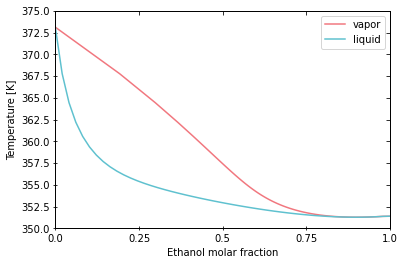

In [62]:
import matplotlib.pyplot as plt
eq = tmo.equilibrium # Thermosteam's equilibrium module
eq.plot_vle_binary_phase_envelope(['Ethanol', 'Water'], P=101325)
plt.show()

Plot the ternary phase diagram of three chemicals in liquid-liquid equilibrium at constant pressure:

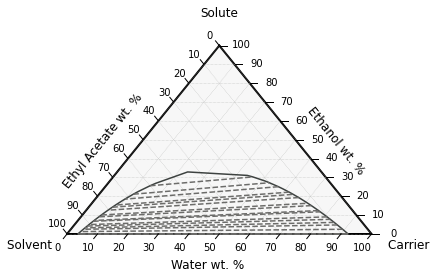

In [63]:
# You'll need to "pip install python-ternary" to run this line
eq.plot_lle_ternary_diagram('Water', 'Ethanol', 'EthylAcetate', T=298.15)
plt.show()

### Vapor-liquid equilibrium

Vapor-liquid equilibrium can be performed by setting 2 degrees of freedom from the following list: `T` (Temperature; in K), `P` (Pressure; in Pa), `V` (Vapor fraction), and `H` (Enthalpy; in kJ/hr).

For example, set vapor fraction and pressure:

In [64]:
s_eq = tmo.Stream('s_eq', Water=10, Ethanol=10)
s_eq.vle(V=0.5, P=101325)
s_eq.show(composition=True)

MultiStream: s_eq
 phases: ('g', 'l'), T: 353.86 K, P: 101325 Pa
 composition: (g) Water    0.386
                  Ethanol  0.614
                  -------  10 kmol/hr
              (l) Water    0.614
                  Ethanol  0.386
                  -------  10 kmol/hr


Note that the stream is a now a MultiStream to manage multiple phases. Each phase can be accessed separately too:

In [65]:
s_eq['l'].show()

Stream: 
 phase: 'l', T: 353.86 K, P: 101325 Pa
 flow (kmol/hr): Water    6.14
                 Ethanol  3.86


In [66]:
s_eq['g'].show()

Stream: 
 phase: 'g', T: 353.86 K, P: 101325 Pa
 flow (kmol/hr): Water    3.86
                 Ethanol  6.14


Note that the phase of these substreams cannot be changed:

In [67]:
s_eq['g'].phase = 'l'

AttributeError: phase is locked

Again, the most convenient way to get and set flow rates is through the `get_flow` and `set_flow` methods:

In [68]:
# Set flow of liquid water
s_eq.set_flow(1, 'gpm', ('l', 'Water'))
s_eq.get_flow('gpm', ('l', 'Water'))

1.0

In [69]:
# Set multiple liquid flows
key = ('l', ('Ethanol', 'Water'))
s_eq.set_flow([10, 20], 'kg/hr', key)
s_eq.get_flow('kg/hr', key)

array([10., 20.])

Chemical flows across all phases can be retrieved if no phase is given:

In [70]:
# Get water and ethanol flows summed across all phases
s_eq.get_flow('kg/hr', ('Water', 'Ethanol'))

array([ 89.61 , 292.678])

However, setting chemical data of MultiStream objects requires the phase to be specified:

In [71]:
s_eq.set_flow([10, 20], 'kg/hr', ('Water', 'Ethanol'))

IndexError: multiple phases present; must include phase key to set chemical data

Similar to Stream objects, all flow rates can be accessed through the `imol`, `imass`, and `ivol` attributes:

In [72]:
s_eq.imol # Molar flow rates

MolarFlowIndexer (kmol/hr):
 (g) Water     3.86
     Ethanol   6.14
 (l) Water     1.11
     Ethanol   0.217


In [73]:
# Index a single chemical in the liquid phase
s_eq.imol['l', 'Water']

1.1101687012358397

In [74]:
# Index multiple chemicals in the liquid phase
s_eq.imol['l', ('Ethanol', 'Water')]

array([0.217, 1.11 ])

In [75]:
# Index the vapor phase
s_eq.imol['g']

array([3.864, 6.136, 0.   ])

In [76]:
# Index flow of chemicals summed across all phases
s_eq.imol['Ethanol', 'Water']

array([6.353, 4.974])

Because multiple phases are present, overall chemical flows in MultiStream objects cannot be set like in Stream objects:

In [77]:
s_eq.imol['Ethanol', 'Water'] = [1, 0]

IndexError: multiple phases present; must include phase key to set chemical data

Chemical flows must be set by phase:

In [78]:
s_eq.imol['l', ('Ethanol', 'Water')] = [1, 0]

One main difference between a [MultiStream](../API/thermosteam/MultiStream.txt) object and a [Stream](../API/thermosteam/Stream.txt) object is that the `mol` attribute no longer stores any data, it simply returns the total flow rate of each chemical. Setting an element of the array raises an error to prevent the wrong assumption that the data is linked:

In [79]:
s_eq.mol

array([3.864, 7.136, 0.   ])

In [80]:
s_eq.mol[0] = 1

ValueError: assignment destination is read-only

Note that for both Stream and MultiStream objects, `get_flow`, `imol`, and `mol` return chemical flows across all phases when given only chemical IDs.

### Liquid-liquid equilibrium

Liquid-liquid equilibrium (LLE) only requires the temperature. Pressure is not a significant variable as liquid fungacity coefficients are not a strong function of pressure. 

In [81]:
tmo.settings.set_thermo(['Water', 'Butanol', 'Octane'])
liquid_mixture = tmo.Stream('liquid_mixture', Water=100, Octane=100, Butanol=5)
liquid_mixture.lle(T=300)
liquid_mixture.show()

MultiStream: liquid_mixture
 phases: ('L', 'l'), T: 300 K, P: 101325 Pa
 flow (kmol/hr): (L) Water    98.5
                     Butanol  1.21
                     Octane   0.00198
                 (l) Water    1.46
                     Butanol  3.79
                     Octane   100
